<a href="https://colab.research.google.com/github/NassarX/Brain-Tumor-MRI-Classifier/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Section

Please ignore that section if you're working locally!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Clone Repo

In [ ]:
# Clone repo and navigate to root directory
!git clone https://github.com/NassarX/Brain-Tumor-MRI-Classifier.git '/content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier'

#### Kaggle credentials

Upload your Kaggle API credentials file (usually named kaggle.json) to the Colab environment.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'
!mv kaggle.json /content/drive/MyDrive/Colab\ Notebooks/

#### Navigate to project path

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Brain-Tumor-MRI-Classifier

**Make sure to pull latest updates each time and after pushing any changes as Colab not saving history !**

In [ ]:
!git pull origin main

# Import required libraries

Here are the libraries and packages that we will be using:

In [1]:
# System
import os
import sys
import configparser
import time
from math import ceil

# Reading and setup data
import cv2
import imutils
from tqdm import tqdm

# Loading datasets
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization


# Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

Import and append our custom modules

In [2]:
%reload_ext autoreload
%autoreload 2
module_path = os.path.abspath(os.path.join('./utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.preprocess import *
from utils.helpers import *

### Load configs

Load the config file to dataset paths.

In [64]:
# Load the config file
config = configparser.ConfigParser()
config.read('config.ini')

# data
dataset_url = config.get('data', 'dataset_url')
downloads_path = config.get('data', 'downloads_path')
dataset_path = config.get('data', 'dataset_path')
furniture_data = config.get('data', 'furniture_data')

# training
models_path = config.get('training', 'models_path')
img_size = int(config.get('training', 'img_size'))
batch_size = int(config.get('training', 'batch_size'))

# Data Preparation

In this step of data preparation we're going to download dataset, unzip and the to crop and extract image contour.

### Download dataset

Download the dataset from Kaggle/Dropbox/etc .. into the `downloads` directory and unzip it.

In [61]:
setup_dataset(dataset_url, downloads_path)

# Exploratory Data Analysis

In [14]:
labels_lv1 = ['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']
labels_lv2 = ['Asian', 'Contemporary', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Traditional', 'Transitional', 'Tropical', 'Victorian']

In [65]:
# Check the number of images in each class
files_path_dict = {}
num_images_per_label = []
label_names = []
for label_lv1 in labels_lv1:
    files_path_dict[label_lv1] = {}
    for label_lv2 in labels_lv2:
        train_path = os.path.join(downloads_path, furniture_data, label_lv1, label_lv2)
        files_path_dict[label_lv1][label_lv2] = [os.path.join(train_path, x) for x in os.listdir(train_path)]
        num_images_per_label.append(len(files_path_dict[label_lv1][label_lv2]))
        label_names.append("{} - {}".format(label_lv1, label_lv2))
        print('Number of images in {} - {}: {}'.format(label_lv1, label_lv2, len(files_path_dict[label_lv1][label_lv2])))

Number of images in beds - Asian: 52
Number of images in beds - Contemporary: 1953
Number of images in beds - Eclectic: 22
Number of images in beds - Farmhouse: 91
Number of images in beds - Industrial: 61
Number of images in beds - Mediterranean: 75
Number of images in beds - Midcentury: 130
Number of images in beds - Modern: 380
Number of images in beds - Rustic: 239
Number of images in beds - Scandinavian: 33
Number of images in beds - Traditional: 1397
Number of images in beds - Transitional: 1719
Number of images in beds - Tropical: 55
Number of images in beds - Victorian: 83
Number of images in chairs - Asian: 381
Number of images in chairs - Contemporary: 4608
Number of images in chairs - Eclectic: 201
Number of images in chairs - Farmhouse: 640
Number of images in chairs - Industrial: 534
Number of images in chairs - Mediterranean: 187
Number of images in chairs - Midcentury: 3585
Number of images in chairs - Modern: 1788
Number of images in chairs - Rustic: 304
Number of image

### Visualize data distribution

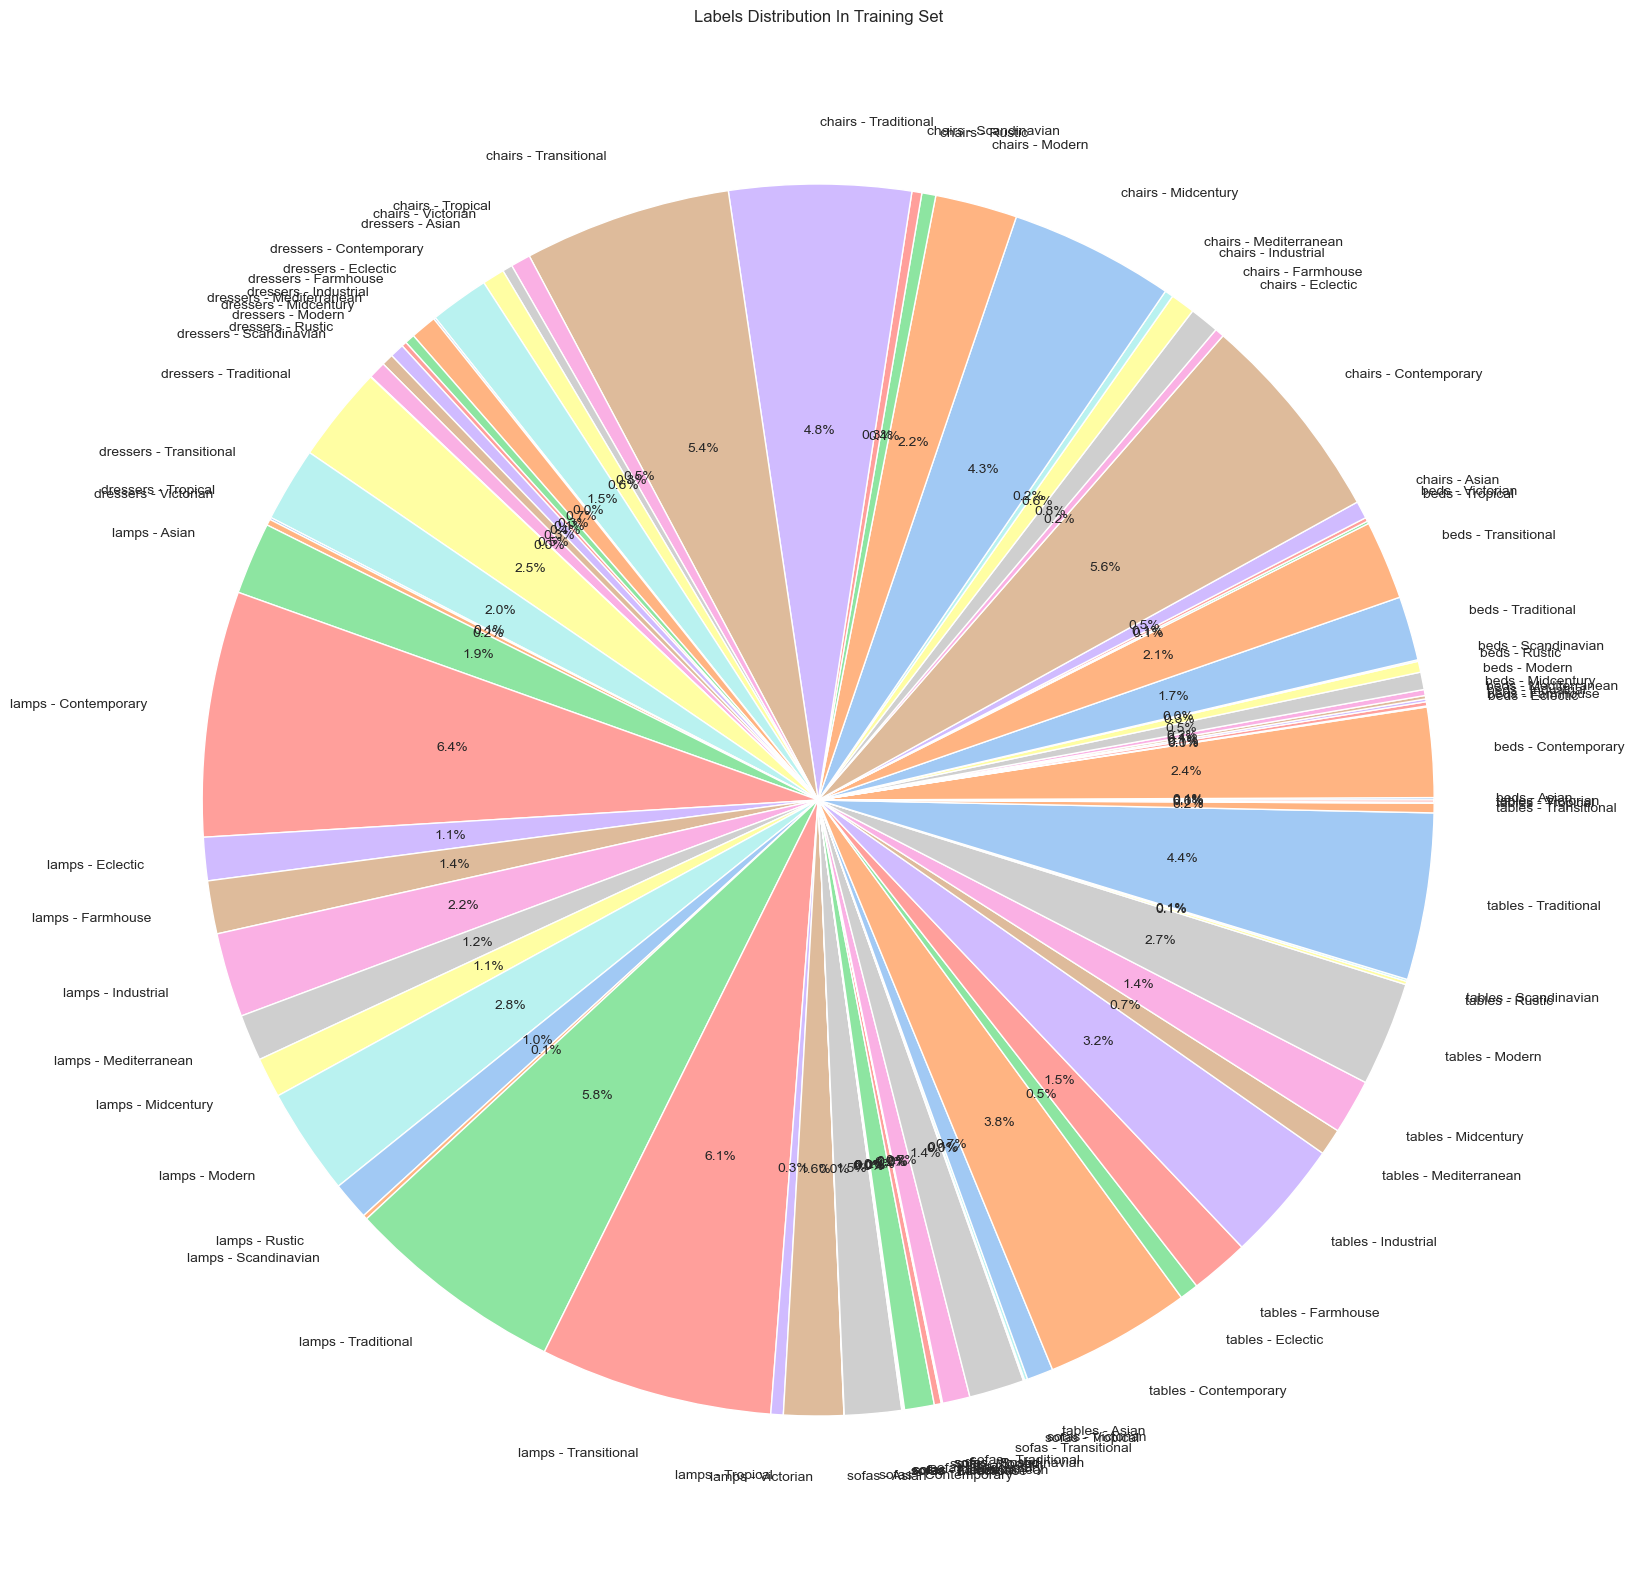

In [25]:
# visualize class distribution in train set
plt.figure(figsize=(42, 20))
colors = sns.color_palette('pastel')

plt.pie(num_images_per_label, labels=label_names, autopct='%1.1f%%', colors=colors)
plt.title('Labels Distribution In Training Set')

plt.show()

### Plot samples

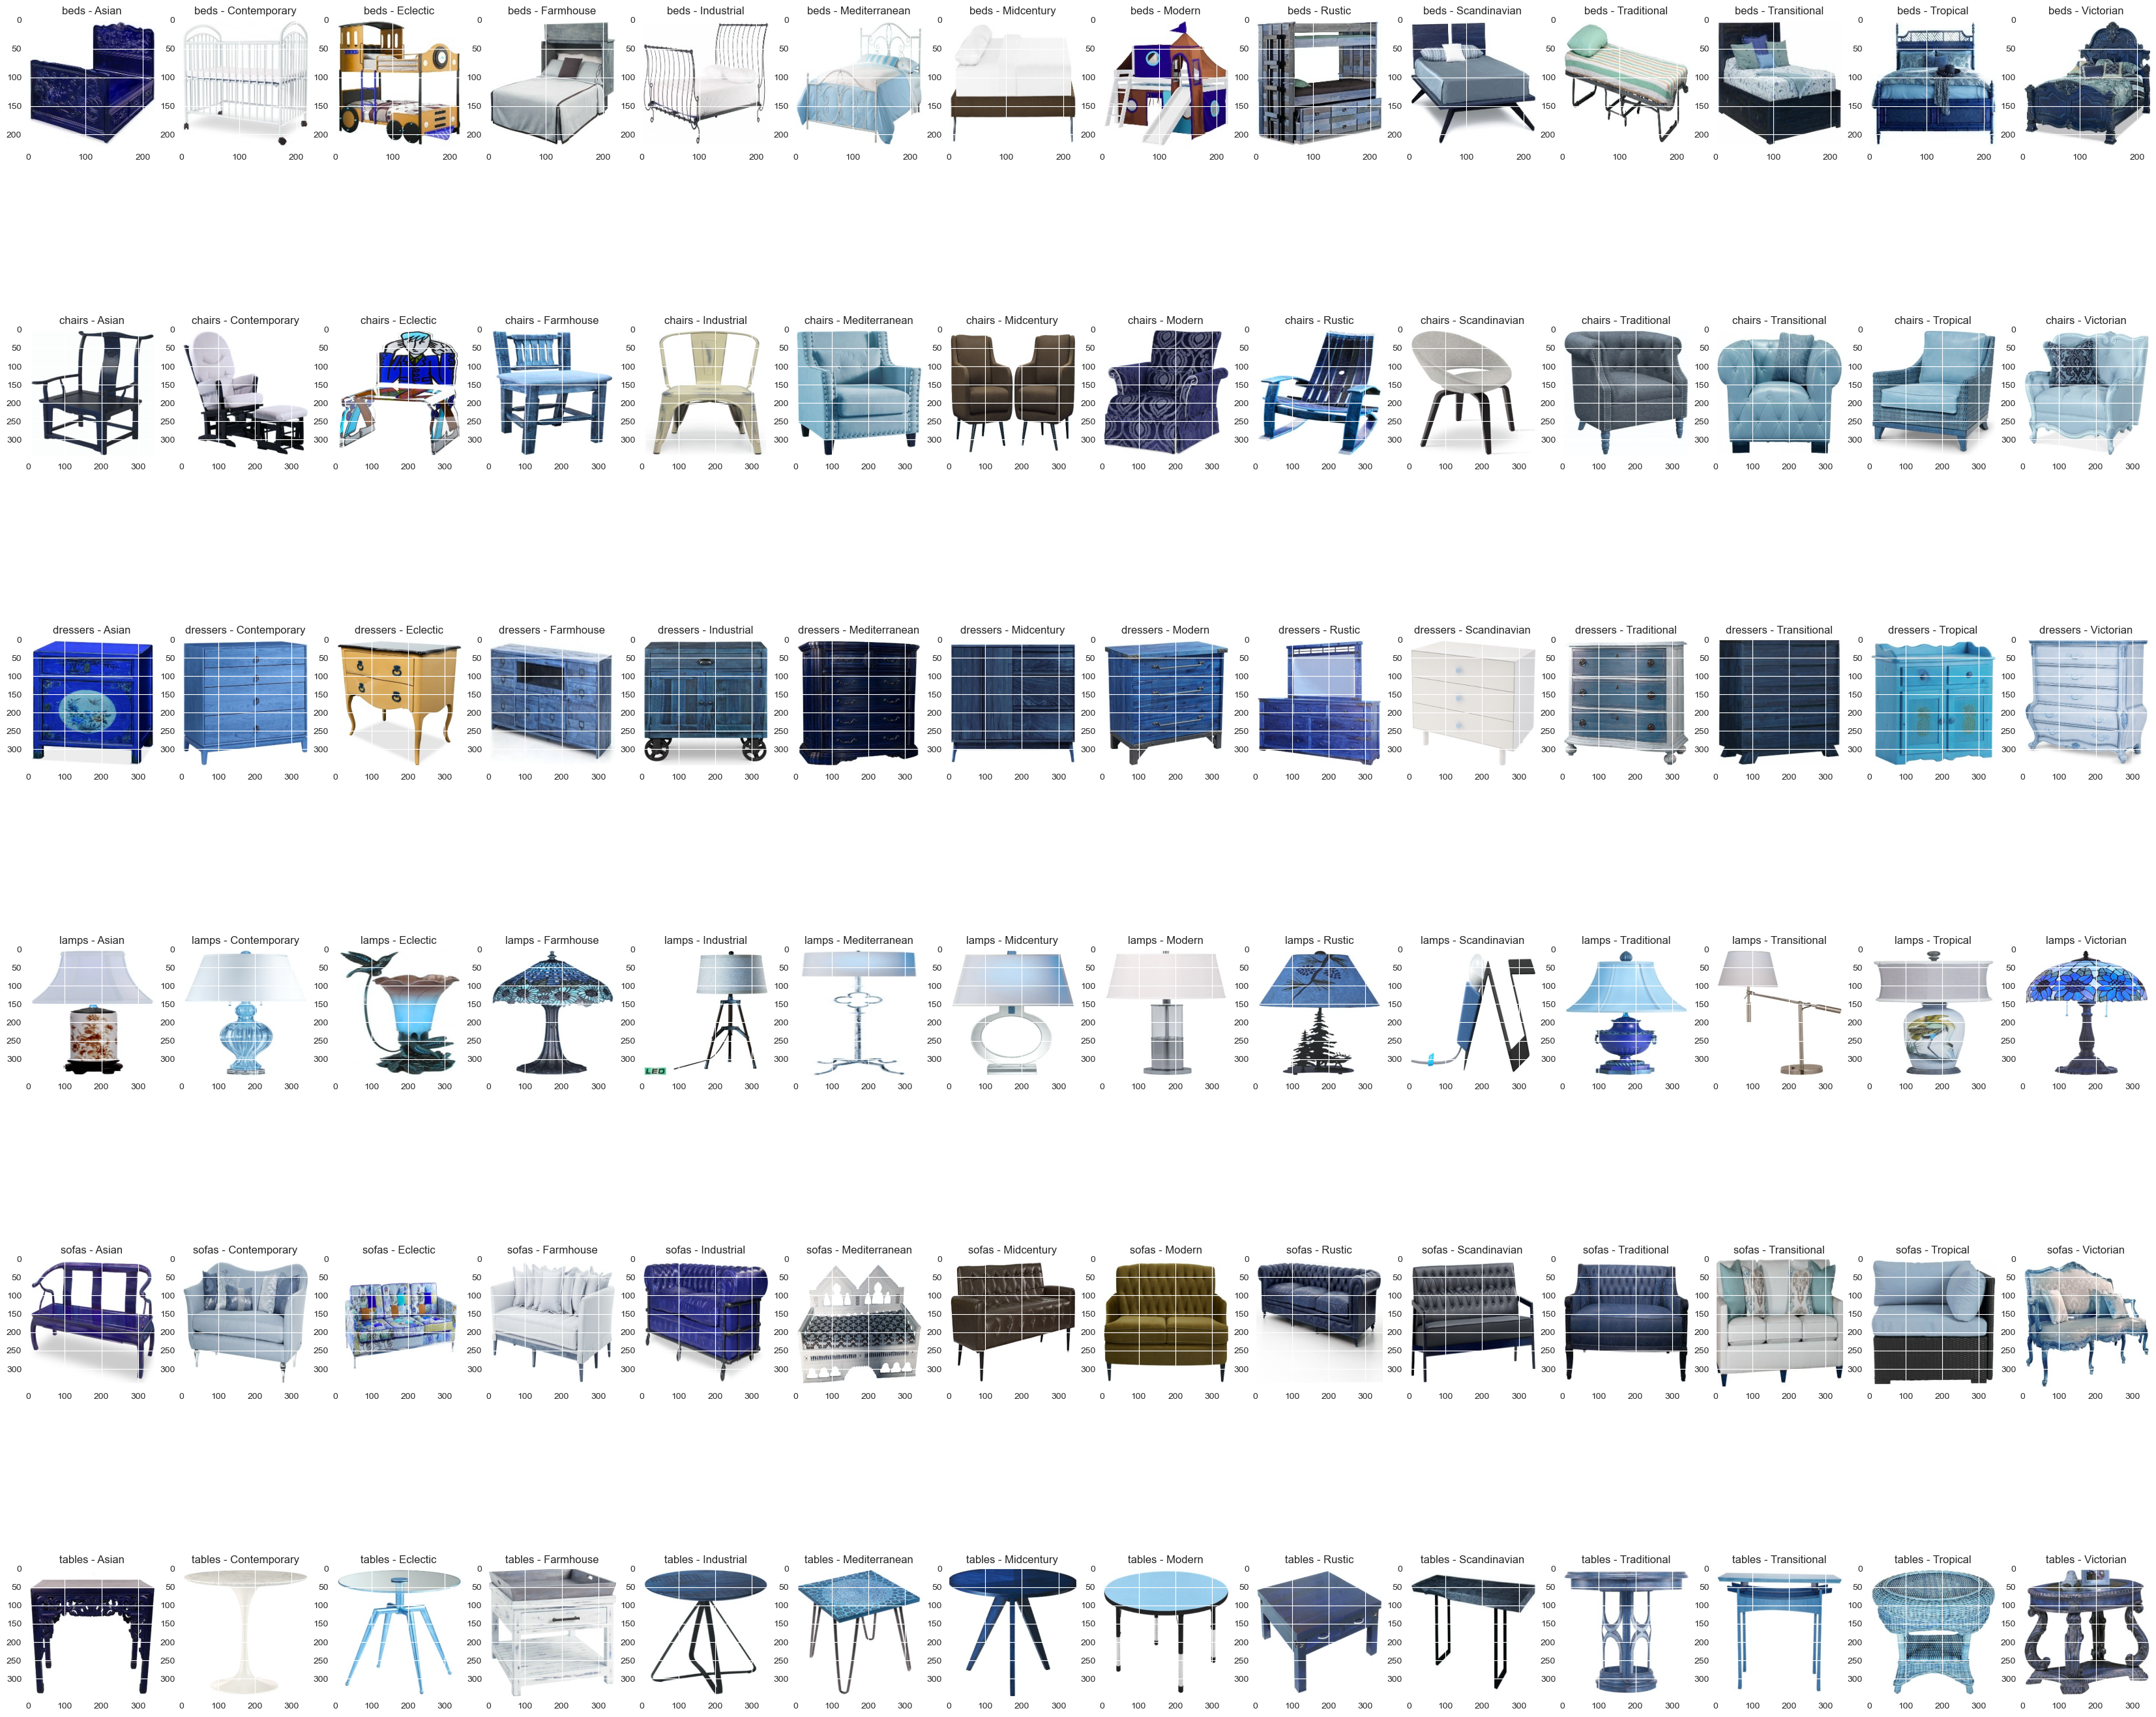

In [50]:
plt.figure(figsize=(42, 36))
index = 0
for label_lv1 in labels_lv1:
    for label_lv2 in labels_lv2:
        path_list = files_path_dict[label_lv1][label_lv2][:1]
        if path_list:
            index += 1
            plt.subplot(len(labels_lv1), len(labels_lv2), index)
            plt.imshow(cv2.imread(path_list[0]))
            plt.title("{} - {}".format(label_lv1, label_lv2))
plt.show()

# Data Preprocessing

In order to load our dataset and labeling each element :

- Extract images
    In order to crop the part that contains only the object of the image, We used a cropping technique to find the extreme top, bottom, left and right points of the object. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).
- Preprocess the image
    - Resize the image to (256, 256) to feed it as an input to the neural network.
    - Apply normalization because we want pixel values to be scaled to the range 0-1.
    - Save processed images into new directory.

### Preprocess data

In [ ]:
preprocess_data(downloads_path, dataset_path)

### Plot Sample (Original | Cropped)

In order to better understand what it's doing, let's grab an image from the original dataset and preprocessed dataset to see the differences.

In [66]:
sample = cv2.imread(os.path.join(downloads_path, furniture_data, 'dressers', 'Asian', '1296asian-dressers.jpg'))
preprocessed_sample = cv2.imread(os.path.join(dataset_path, furniture_data, 'dressers', 'Asian', '1296asian-dressers.jpg'))

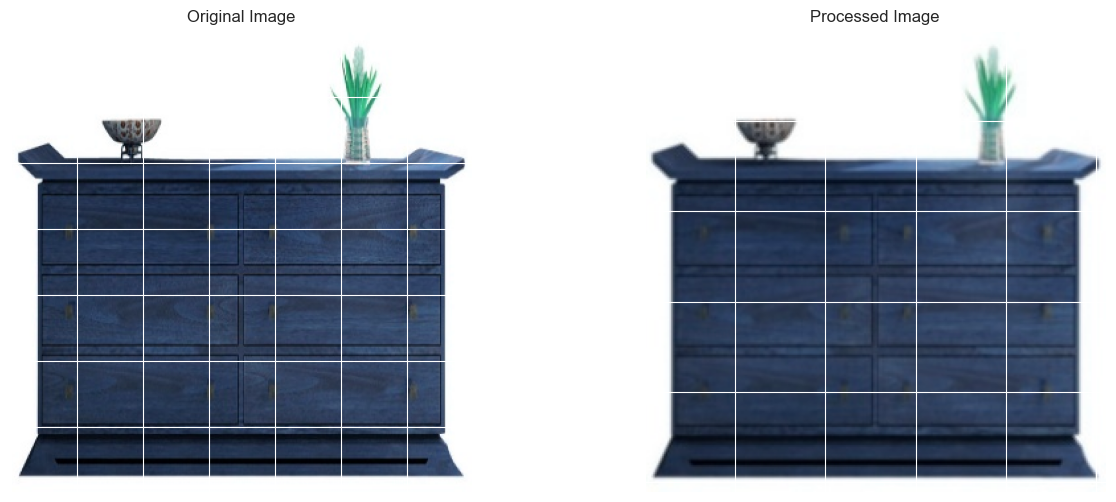

In [67]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample)
plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False,
                labeltop=False, labelleft=False, labelright=False)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_sample)
plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False,
                labeltop=False, labelleft=False, labelright=False)
plt.title('Processed Image')
plt.show()

### Load datasets

Load preprocessed images and its multi-labels.

In [88]:
data = os.path.join(dataset_path, furniture_data)
labels = {'lv1': labels_lv1, 'lv2': labels_lv2}

df = load_data(data, labels)
df.head(5)

Loaded beds dataset successfully 6290 .
Loaded chairs dataset successfully 27852 .
Loaded dressers dataset successfully 35393 .
Loaded lamps dataset successfully 62816 .
Loaded sofas dataset successfully 66846 .
Loaded tables dataset successfully 83016 .


file  beds  chairs   
50915  dataset/furniture_dataset/Bonn_Furniture_Style...     0       0  \
54089  dataset/furniture_dataset/Bonn_Furniture_Style...     0       0   
6887   dataset/furniture_dataset/Bonn_Furniture_Style...     0       1   
8175   dataset/furniture_dataset/Bonn_Furniture_Style...     0       1   
35193  dataset/furniture_dataset/Bonn_Furniture_Style...     0       0   

       dressers  lamps  sofas  tables  Asian  Contemporary  Eclectic  ...   
50915         0      1      0       0      0             0         0  ...  \
54089         0      1      0       0      0             0         0  ...   
6887          0      0      0       0      0             1         0  ...   
8175          0      0      0       0      0             1         0  ...   
35193         1      0      0       0      0             0         0  ...   

       Industrial  Mediterranean  Midcentury  Modern  Rustic  Scandinavian   
50915           0              0           0       0       1             0  \
54089           0              0           0       0       0             0   
6887            0              0           0       0       0             0   
8175            0              0           0       0       0             0   
35193           0              0           0       0       0             0   

       Traditional  Transitional  Tropical  Victorian  
50915            0             0         0          0  
54089            1             0         0          0  
6887             0             0         0          0  
8175             0             0         0          0  
35193            0             1         0          0  

[5 rows x 21 columns]

In [89]:
df_copy = df.copy()

In [98]:
df.columns

Index(['file', 'beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables',
       'Asian', 'Contemporary', 'Eclectic', 'Farmhouse', 'Industrial',
       'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian',
       'Traditional', 'Transitional', 'Tropical', 'Victorian'],
      dtype='object')

In [114]:
# IMAGE SHAPE
IMG_SHAPE = (img_size, img_size, 3)

# Extract image file paths into x
X = df['file']

# Extract labels into y
y = df.drop(['file'], axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [115]:
print ("number of training samples = " + str(X_train.shape[0]))
print ("number of validation samples = " + str(X_val.shape[0]))
print ("number of test samples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training samples = 53129
number of validation samples = 13283
number of test samples = 16604
X_train shape: (53129,)
Y_train shape: (53129, 20)
X_val shape: (13283,)
Y_val shape: (13283, 20)
X_test shape: (16604,)
Y_test shape: (16604, 20)


In [122]:
X_train_df = X_train.to_frame()

# Data Augmentation
Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc of each training instances.

In order to make the most of our few training samples here, we augment them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

### Build data generator

Define an image data generator to apply random transformations to the training data.

In [148]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.concat([X_train, y_train], axis=1),
    directory=None,
    x_col='file',
    y_col=['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables', 'Asian', 'Contemporary', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Traditional', 'Transitional', 'Tropical', 'Victorian'],
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='raw',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.concat([X_val, y_val], axis=1),
    directory=None,
    x_col='file',
    y_col=['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables', 'Asian', 'Contemporary', 'Eclectic', 'Farmhouse', 'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Traditional', 'Transitional', 'Tropical', 'Victorian'],
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='raw',
    subset='validation'
)

Found 42504 validated image filenames.
Found 2656 validated image filenames.


### Plot sample

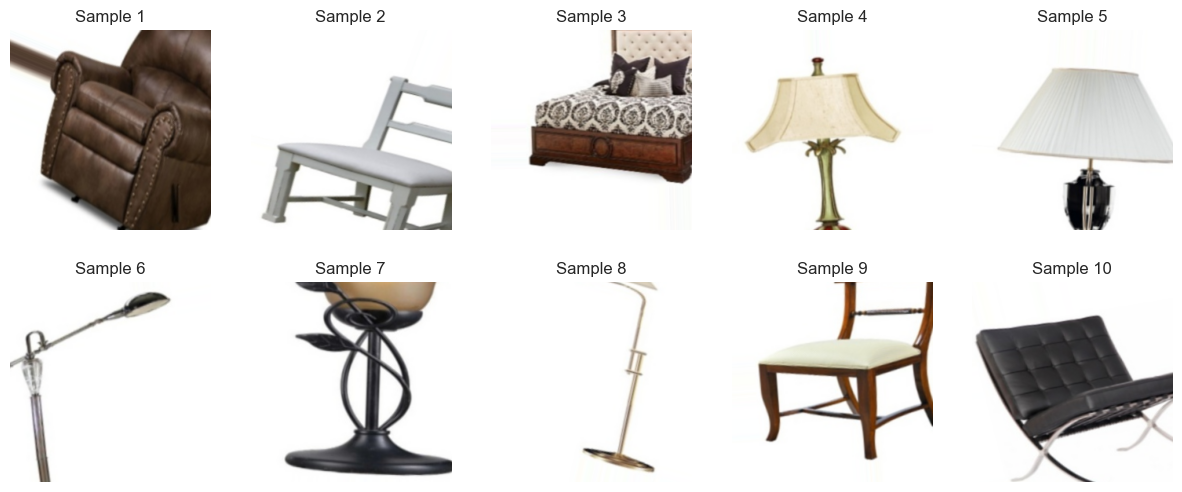

In [150]:
# display 10 augmented images from X_train
x_batch, y_batch = next(train_generator)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    row = i // 5
    col = i % 5
    ax[row, col].imshow(x_batch[i])
    ax[row, col].set_title(f"Sample {i+1}")
    ax[row, col].axis("off")

plt.show()

# Modeling

### Model Callbacks

Here we're setting up the necessary tools for optimizing the model's performance during training and evaluation.

- `TensorBoard` A tool provided by TensorFlow allows can help understand the behavior of your model, identify potential problems, and optimize training process.

- `ModelCheckpoint` A callback provided by Keras allows to save the weights of your model during training and to keep track of the best-performing version of your model.

In [151]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [152]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Learning Transfer

Since our dataset used is small, one method of addressing this lack of data in a given domain is to leverage data from a similar domain, a technique known as Transfer Learning (TL).

TL means using what is learned from one task and applying that to another task without learning from scratch.

![learning-transfer-concepts](assets/learning-transfer.png)

### VGG16

#### Network Architecture

VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. Similar to AlexNet, only 3x3 convolutions, but lots of filters.

 It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another.


![unnet-arch](assets/vgg16.png)

#### Model Declaration

In [153]:
# VGG16
vgg = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = BatchNormalization()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=20, activation='softmax')(x)

vgg16_model = Model(inputs=vgg.input, outputs=x)

#### Model Compiling

In [154]:
vgg16_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Model Training

In [155]:
train_generator.image_shape

(256, 256, 3)

In [156]:
vgg16_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/10
1329/1329 [==============================] - ETA: 0s - loss: 442682.4375 - accuracy: 0.2059

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.34.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.34.model/assets


1329/1329 [==============================] - 529s 397ms/step - loss: 442682.4375 - accuracy: 0.2059 - val_loss: 2162832.0000 - val_accuracy: 0.3377
Epoch 2/10
  26/1329 [..............................] - ETA: 7:39 - loss: 1970044.7500 - accuracy: 0.1310

KeyboardInterrupt: 

#### Plot Loss & Accuracy

#### Model Evaluation

In [ ]:
vgg16_model.evaluate(x=X_val, y=y_val)

In [ ]:
y_val_pred = vgg16_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)
co_mat = confusion_matrix(y_val, y_val_pred_arg, labels)

print(co_mat)
print(classification_report(y_val, y_val_pred_arg, labels))

### EfficientNet

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of a CNN such as depth/width/resolution using a compound coefficient.

We are going to initialize EfficientNetB1 model and use weight=‘imagenet’.

[ImageNet](https://www.image-net.org/) is a large visual database designed for use in visual object recognition software research.

#### Network Architecture

To Add our own layers on the top of EfficientNetB1:

- `GlobalAveragePooling2D` to replace fully connected layers. It takes the average of each feature map and feed the resulting vector directly into the softmax layer.
- `Dropout` to prevent overfitting by reducing the number of neurons.
- `Dense` as output layer with activation softmax since this is a multi-class classification problem.

![efficientnet-arch](assets/efficientnet.png)

EfficientNet model has 4 component:
- Stem layer
- final layer
- Sub-blocks: each block has sub-blocks.
- Modules: each sub-blocks has modules.

![efficient-moules](assets/efficient-moules.png)

#### Model Declaration

In [160]:
# build the model
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

effnet_model = effnet.output
effnet_model = GlobalAveragePooling2D()(effnet_model)
effnet_model = Dropout(0.5)(effnet_model)
effnet_model = Dense(20, activation='softmax')(effnet_model)
effnet_model = Model(inputs=effnet.input, outputs=effnet_model)

effnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

#### Model Compiling

In [161]:
effnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Model Training

In [162]:
#train the model
effnet_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/10
  83/1329 [>.............................] - ETA: 21:09 - loss: 6.5757 - accuracy: 0.6299

KeyboardInterrupt: 

#### Plot Loss & Accuracy

In [ ]:
history = effnet_model.history
plot_metrics(history.history)

#### Model Evaluation

In [ ]:
effnet_model.evaluate(x=X_val, y=y_val)

In [ ]:
y_val_pred = effnet_model.predict(X_val)
y_val_pred_arg = y_val_pred.argmax(axis=1)
co_mat = confusion_matrix(y_val, y_val_pred_arg, labels)

print(co_mat)
print(classification_report(y_val, y_val_pred_arg, labels))

## Results Interpretation

Let's experiment with the best model (the one with the best validation accuracy):

**Concretely, our `EfficientNetB1` model with validation accuracy ~97% Yeaaah !!**

### Best model

Let's for last time evaluate best model on Testing dataset

In [ ]:
loss_test, acc_test = effnet_model.evaluate(x=X_test, y=y_test)

### Best model Accuracy

In [ ]:
print (f"Test Loss = {loss_test}")
print (f"Test Accuracy = {acc_test}")

### Best model F1-Score

On testing dataset

In [ ]:
y_test_prob = np.argmax(effnet_model.predict(X_test), axis=1)

f1_score_test = compute_f1_score(y_test, y_test_prob)
print(f"F1 score on Testing: {f1_score_test}")

## Conclusion

Now, the model detects brain tumor with:

- `98.0%` accuracy on the test set.
- `0.97` f1 score on the test set.

These results are very good considering that the data is balanced.


Performance Table:

| Validation set | Test set |
|----------------|----------|
| Accuracy       | 96%      | 98% |
| F1 score       | 0.96     | 0.97 |

Hooray!